# Prediction of melting point of organic molecules by linear regression

We want to create a model that will predict the melting point of organic molecules, based on the 2D molecular structure (what atoms and bonds are present). We will use a linear regression model, which is probably the simplest tool in our machine learning toolbox. The model will be trained on experimental data for melting points of organic molecules.

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Properties of molecules
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

The data we will be using is from the _Jean-Claude Bradley Double Plus Good (Highly Curated and Validated) Melting Point Dataset_, available at https://doi.org/10.6084/m9.figshare.1031638.v1 

It is described as:

> 3041 highly curated and validated melting point measurements taken from the Jean-Claude Bradley Open Melting Point Dataset. Values were only kept if there were multiple measurements and the range of values was between 0.01 °C and 5 °C inclusive. `csid` corresponds to Chemspider ID

It is available as an Excel file, which is downloaded and loaded into a Pandas dataframe:

In [2]:
url = 'https://figshare.com/ndownloader/files/1503991'
df = pd.read_excel(url)

## Content of the dataset

We first examine the content of the data set: how many records (molecules) does it have? What values are present? What is their range?

In [3]:
df.head()

,key,name,smiles,mpC,csid,link,source,count,min,max,range
0,27956,cyclobutylmethane,C1(CCC1)C,-161.51,11232,http://pubs.acs.org/doi/abs/10.1021/ja01142a048,Lemaire HP; Livingston RL Journal of the Ameri...,2,-161.51,-161.5,0.01
1,16005,Nitrogen oxide,[O-][N+]#N,-90.80,923,http://msds.chem.ox.ac.uk/,academic website,2,-90.81,-90.8,0.01
2,16127,Sulfuryl difluoride,FS(F)(=O)=O,-135.80,16647,http://msds.chem.ox.ac.uk/,academic website,2,-135.82,-135.8,0.02
3,17138,disopyramide,CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C,94.80,3002,http://dx.doi.org/10.1021/ci700307p,Hughes LD; Palmer DS; Nigsch F and Mitchell JB...,2,94.75,94.8,0.05
4,15628,Bromine,BrBr,-7.20,22817,http://msds.chem.ox.ac.uk/,academic website,2,-7.25,-7.2,0.05


In [4]:
df.describe()

,key,mpC,csid,count,min,max,range
count,3041.000000,3041.000000,3.041000e+03,3041.000000,3041.000000,3041.000000,3041.000000
mean,10771.570865,62.848159,2.027796e+06,2.798422,62.229536,63.879092,1.649556
std,6875.518120,96.007422,5.474893e+06,1.275456,95.877685,96.229485,1.293567
min,10.000000,-188.000000,1.800000e+01,2.000000,-188.000000,-187.600000,0.010000
25%,5148.000000,5.000000,7.634000e+03,2.000000,4.800000,5.600000,0.500000
50%,13103.000000,64.000000,1.282900e+04,2.000000,62.750000,65.000000,1.000000
75%,15269.000000,129.500000,6.675900e+04,3.000000,129.000000,130.800000,2.500000
max,28644.000000,438.000000,2.142902e+07,16.000000,437.300000,440.000000,5.000000


In [5]:
numCSID = len(df['csid'])
numUniqueCSID = len(set(df['csid']))
numSMILES = len(df['smiles'])
numUniqueSMILES = len(set(df['smiles']))

print(f'{numCSID} CSID found, {numUniqueCSID} unique')
print(f'{numSMILES} SMILES keys found, {numUniqueSMILES} unique')

3041 CSID found, 3041 unique
3041 SMILES keys found, 3041 unique


There are 3041 records, one of each molecule. All molecules appear to be different, based on ChemSpider ID, and all SMILES strings are unique too.

Here are the data present for each molecule:
- `key`: identifier of unknow origin
- `name`: common name
- `smiles`: the molecular structure as [SMILES string](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
- `csid`: [ChemSpider](http://www.chemspider.com) identifier
- `mpC`: a consensus value of melting point, in °C
- `link` and `source`: where that value comes from
- `count`: number of melting point measurements used in determining the value
- `min` and `max`: minimum and maximum of the melting point values reported
- `range = max - min`, accuracy of the melting point

## Generating descriptors

We want our model to predict the melting point from the chemical structure of a molecule. In the dataset, this structural information is present in two different ways:
- the common name of the molecule
- the SMILES representation of its structure

The common name may be familiar to many chemists, but it is not easy to parse by a computer program, and some names may be ambiguous. The [SMILES representation](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), on the other hand, is designed for the purpose of computer representation, so we will use that.

We will not be able to use a SMILES string as input to the linear regression model, however. We need to transform this string representation into a series of numbers, a numerical vector. This process is called **featurization**. There are many ways to featurize molecular structures, including calculation of different types of “fingerprints” of the molecules, in an automated way.

We will follow a much simpler approach here, by calculating for each molecule some key numerical characteristics that we _think_ have chemical meaning and could influence the melting point. We are using our chemical insight to choose the set of features relevant for the prediction of melting point. For example, the molar mass is definitely important (heavier molecules melt at higher temperature).

We'll use the `rdkit` module to perform two tasks: (i) load molecular representatoins from strings; (ii) calculate the descriptors we want. First, let's see it in action on one of the molecules in the dataset:

Molecular name: 2-(3-chlorophenoxy)propionic acid
SMILES: CC(C(=O)O)Oc1cccc(c1)Cl


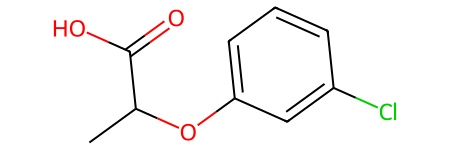

In [6]:
print('Molecular name:', df['name'][1901])
print('SMILES:', df['smiles'][1901])
Chem.MolFromSmiles(df['smiles'][1901])

`rdkit` is able to load the 2D representation of the molecular structure from the SMILES representation, and display it nicely in our notebook. We can also calculate some properties:

In [7]:
m = Chem.MolFromSmiles(df['smiles'][1901])
print('Number of atoms:', len(m.GetAtoms()))
print('Molar mass:', Descriptors.MolWt(m))
print('Number of H-bond acceptors:', Descriptors.NumHAcceptors(m))
print('Number of H-bond donors:', Descriptors.NumHDonors(m))
print('Number of aromatic rings:', rdMolDescriptors.CalcNumAromaticRings(m))

Number of atoms: 13
Molar mass: 200.62099999999998
Number of H-bond acceptors: 2
Number of H-bond donors: 1
Number of aromatic rings: 1


We create a function `calcDescriptors` that will compute, for a given molecule, the four descriptors listed above. This function will be applied to all rows of the data set. We make a special case (return zeros) if the parsing of the SMILES string failed.

In [8]:
def calcDescriptors(row):
    m = Chem.MolFromSmiles(row['smiles'])
    if m is None:
        # Could not create from SMILES
        return [0, 0, 0, 0]
    return [Descriptors.MolWt(m), Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m), rdMolDescriptors.CalcNumAromaticRings(m)]

In [9]:
df.head().apply(calcDescriptors, axis='columns', result_type='expand')

,0,1,2,3
0,70.135,0.0,0.0,0.0
1,44.013,0.0,2.0,0.0
2,102.061,0.0,2.0,0.0
3,339.483,1.0,3.0,2.0
4,159.808,0.0,0.0,0.0


We compute the descriptors for the first 5 molecules in the dataset, using `df.head()`, and it appears to be working well. So now we apply that function to the whole data set, adding the descriptors as four new columns:

In [10]:
df[['mass', 'hDonors', 'hAcceptors', 'aromaticRings']] = df.apply(calcDescriptors, axis='columns', result_type='expand')

[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 31 32 33 34
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 15 16
[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[14:31:05] Can't kekulize mol.  Unkekuliz

## Curation of data

😭 We are seeing some RDKit errors in the output. These messages (`Can't kekulize mol.  Unkekulized atoms`) are related to the reading of SMILES strings for aromatic systems. How many errors exactly? Let us see how many descriptors have a zero for molar mass (which should never happen):

In [11]:
sum(df['mass'] == 0)

16

So that's 16 molecules (out of 3041) that couldn't be properly generated from the SMILES string. We can have a look at them:

In [12]:
df[df['mass'] == 0]

,key,name,smiles,mpC,csid,link,source,count,min,max,range,mass,hDonors,hAcceptors,aromaticRings
308,15039,1H-Pyrrole,c1cccn1,-23.0,7736,http://msds.chem.ox.ac.uk/,academic website,2,-23.4,-23.0,0.4,0.0,0.0,0.0,0.0
370,17145,fludioxonil,N#Cc3cncc3c1cccc2OC(F)(F)Oc12,199.4,77916,http://dx.doi.org/10.1021/ci700307p,Hughes LD; Palmer DS; Nigsch F and Mitchell JB...,2,199.4,199.8,0.4,0.0,0.0,0.0,0.0
662,15899,"Methyl (3beta,16beta,17alpha,18beta,20alpha)-1...",COc1cc(cc(OC)c1OC)/C=C/C(=O)O[C@@H]3C[C@@H]4CN...,238.0,4444446,http://msds.chem.ox.ac.uk/,academic website,2,238.0,238.5,0.5,0.0,0.0,0.0,0.0
697,15035,1H-Imidazole,c1cncn1,90.0,773,http://msds.chem.ox.ac.uk/,academic website,3,90.0,90.5,0.5,0.0,0.0,0.0,0.0
698,15036,1H-Indole,c1cccc2nccc12,52.0,776,http://msds.chem.ox.ac.uk/,academic website,3,52.0,52.5,0.5,0.0,0.0,0.0,0.0
728,15521,5-Methyl-1H-benzotriazole,Cc1cc2nnnc2cc1,81.5,8381,http://msds.chem.ox.ac.uk/,academic website,3,81.0,81.5,0.5,0.0,0.0,0.0,0.0
933,14777,(2'beta)-22-Oxovincaleukoblastine,O=C(OC)[C@@]2(C[C@H]4C[C@@](O)(CC)C[N@@](CCc1c...,219.0,5758,http://msds.chem.ox.ac.uk/,academic website,2,219.0,220.0,1.0,0.0,0.0,0.0,0.0
1305,15534,6-Nitro-1H-benzimidazole,[O-][N+](=O)c1ccc2ncnc2c1,208.0,6927,http://msds.chem.ox.ac.uk/,academic website,3,208.0,209.0,1.0,0.0,0.0,0.0,0.0
1364,15284,2-Methyl-4-nitro-1H-imidazole,[O-][N+](=O)c1cnc(C)n1,253.0,12236,http://msds.chem.ox.ac.uk/,academic website,3,252.0,253.0,1.0,0.0,0.0,0.0,0.0
1820,15031,1H-Benzimidazole,c1cccc2ncnc12,171.0,5593,http://msds.chem.ox.ac.uk/,academic website,4,170.5,172.0,1.5,0.0,0.0,0.0,0.0


All these molecules have an aromatic part, with nitrogen atom in the aromatic ring, and `rdkit` does not handle their SMILES strings. The simplest is 1H-indole:

In [13]:
Chem.MolFromSmiles('c1cccn1')

[14:31:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


So is it a problem in `rdkit`? No, it is actually an invalid SMILES string. We can read in [Wikipedia](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system):
> Aromatic nitrogen bonded to hydrogen, as found in pyrrole must be represented as `[nH]`

so the proper SMILES should be `c1ccc[nH]1`. We can check that, indeed, it works:

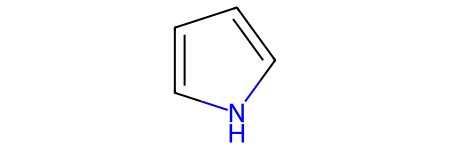

In [14]:
Chem.MolFromSmiles('c1ccc[nH]1')

This is why checking and curating the data is important: we don't want some nonsensical values to influence the training of our model. We could manually edit the SMILES strings and fix them, but for this tutorial the simplest option is to drop those 16 molecules from out data set:

In [15]:
df = df[df['mass'] > 0]
print(f'We now have {len(df)} molecules')

We now have 3025 molecules


Then, we can look at some statistics on our brand new descriptors, to help us get a sense of the chemical diversity of the dataset.

In [16]:
df.describe()

,key,mpC,csid,count,min,max,range,mass,hDonors,hAcceptors,aromaticRings
count,3025.000000,3025.000000,3.025000e+03,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000
mean,10746.770248,62.254496,2.036780e+06,2.798678,61.636536,63.284635,1.648099,180.528716,0.678678,1.783471,0.933223
std,6885.046638,95.663463,5.487405e+06,1.278174,95.537341,95.885451,1.291075,80.114001,0.861752,1.484173,0.888736
min,10.000000,-188.000000,1.800000e+01,2.000000,-188.000000,-187.600000,0.010000,16.043000,0.000000,0.000000,0.000000
25%,5112.000000,5.000000,7.659000e+03,2.000000,4.500000,5.500000,0.500000,129.247000,0.000000,1.000000,0.000000
50%,12815.000000,63.000000,1.285800e+04,2.000000,62.000000,64.500000,1.000000,166.180000,0.000000,2.000000,1.000000
75%,15264.000000,129.000000,6.684700e+04,3.000000,128.000000,130.000000,2.500000,214.648000,1.000000,3.000000,1.000000
max,28644.000000,438.000000,2.142902e+07,16.000000,437.300000,440.000000,5.000000,959.171000,8.000000,14.000000,8.000000


Molar mass goes from 16 g/mol to 959 g/mol, and our dataset includes molecules with up to 8 aromatic rings. Let's check that one!

In [17]:
df[df['aromaticRings'] == 8]

,key,name,smiles,mpC,csid,link,source,count,min,max,range,mass,hDonors,hAcceptors,aromaticRings
605,8188,octaphenylcyclotetrasiloxane,c1ccc(cc1)[Si]2(O[Si](O[Si](O[Si](O2)(c3ccccc3...,201.0,61642,http://www.alfa.com/en/GP100W.pgm?DSSTK=L06130,Alfa Aesar,2,200.5,201.0,0.5,793.188,0.0,4.0,8.0


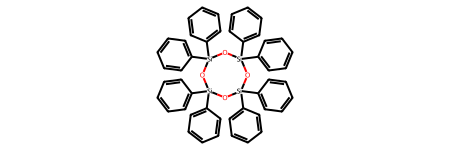

In [18]:
Chem.MolFromSmiles(df[df['aromaticRings'] == 8]['smiles'].iloc[0])

We can plot some histograms of the descriptors, as well. It is always good to have an understanding of the data we are working with, its limitations, etc.

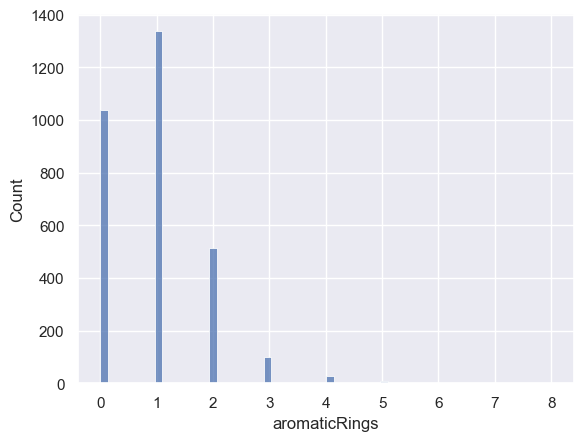

In [19]:
_ = sns.histplot(data=df, x='aromaticRings')

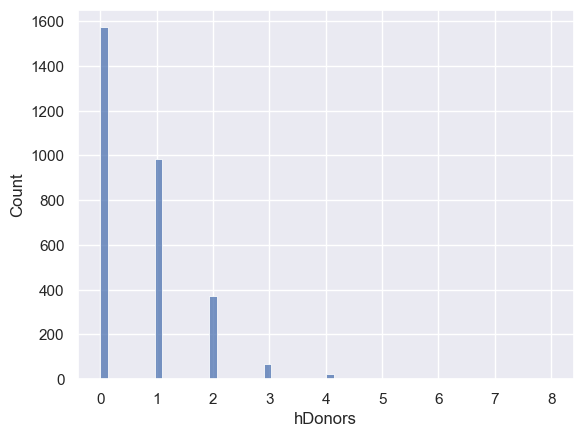

In [20]:
_ = sns.histplot(data=df, x='hDonors')

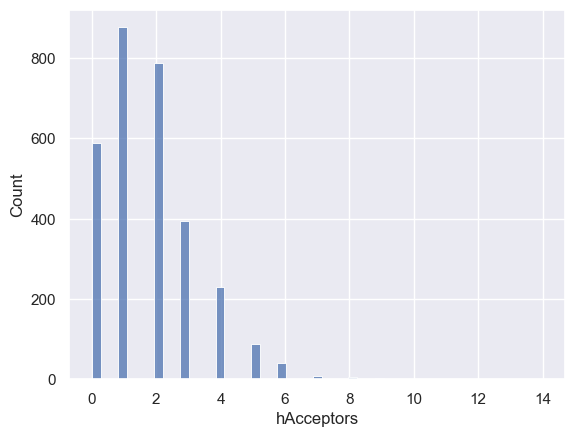

In [21]:
_ = sns.histplot(data=df, x='hAcceptors')

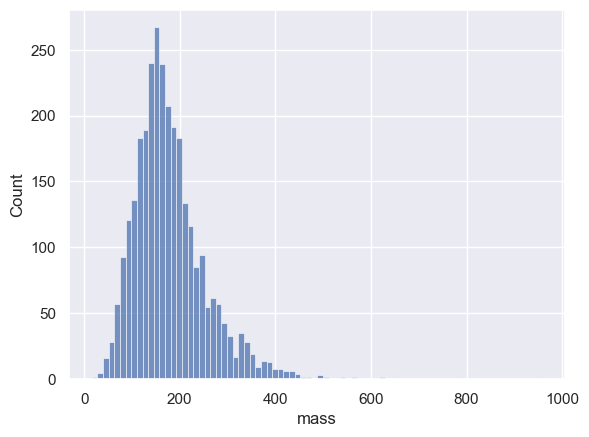

In [22]:
_ = sns.histplot(data=df, x='mass')

## Linear regression: melting point and molar mass

The first factor we want to analyze, because chemical intuition tells us it might be an important factor in determining the melting point of molecules, is the molar mass.

Here is the correlation between boiling point of alkanes (in °C) and their molar mass (in g/mol). The dataset contains 102 alkane molecules, taken from https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics_OLCC_(2019)/5._Quantitative_Structure_Property_Relationships/5.4%3A_Python_Assignment
Such clear correlation is due to the chemical similarity of the molecules (all alkanes), of course… but this is a lead to follow!

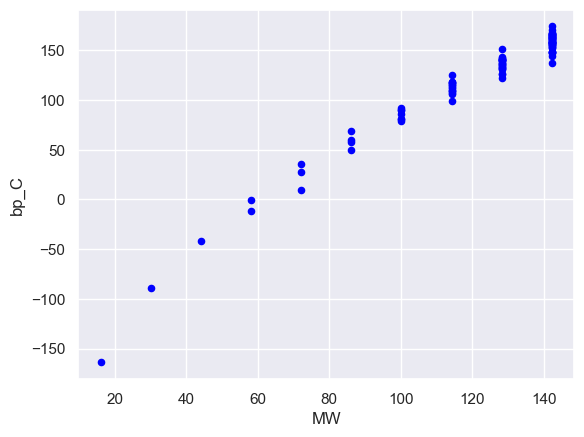

In [23]:
bp = pd.read_csv("boiling_point_alkanes.csv")
_ = bp.plot.scatter(x='MW', y='bp_C', c='blue')

We want to see whether the same is true of our own data set, which is bigger and more diverse in terms of chemical nature. We do a scatterplot:

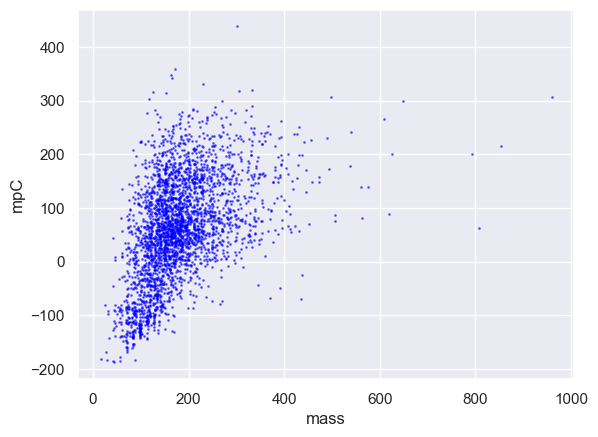

In [24]:
_ = df.plot.scatter(x='mass', y='mpC', s=1, c='blue', alpha=0.5)

Although the correlation is not excellent, the eye suggests that there is some trend still. Let's explore that further and train a linear regression. In terms of machine learning, our target is the melting point, and we have only a single feature (or descriptor): the molar mass.

In [25]:
data = df[['mass']]
target = df['mpC']
linear_regression = LinearRegression()
linear_regression.fit(data, target)

LinearRegression()

We have fitted the linear regression based on our data, and now we want to calculate the error between the predicted melting points and the real melting points. We can also visualize the agreement by plotting the two (predicted vs. real) in a scatterplot.

The mean squared error of the optimal model is 7062.9
The mean absolute error of the optimal model is 67.4 °C


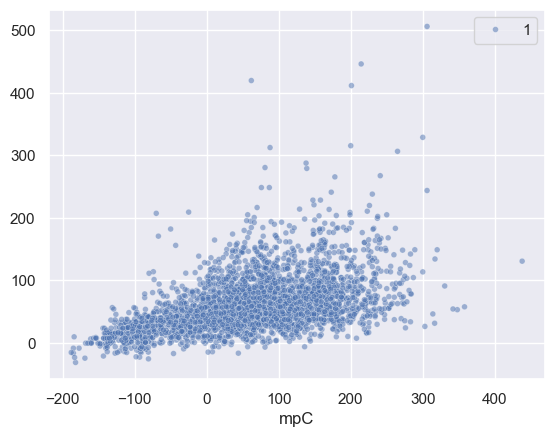

In [26]:
predicted = linear_regression.predict(data)
model_error = mean_squared_error(target, predicted)
print(f"The mean squared error of the optimal model is {model_error:.1f}")
model_error = mean_absolute_error(target, predicted)
print(f"The mean absolute error of the optimal model is {model_error:.1f} °C")

_ = sns.scatterplot(x=target, y=predicted, size=1, alpha=0.5)

Graphically, the agreement is not very satisfying. In particular, we see tha values with low melting point (x < 0) are badly predicted. The predicted values does not extend to large negative values. We can see that further by comparing the histograms of real values (in blue) and predicted values (in red):

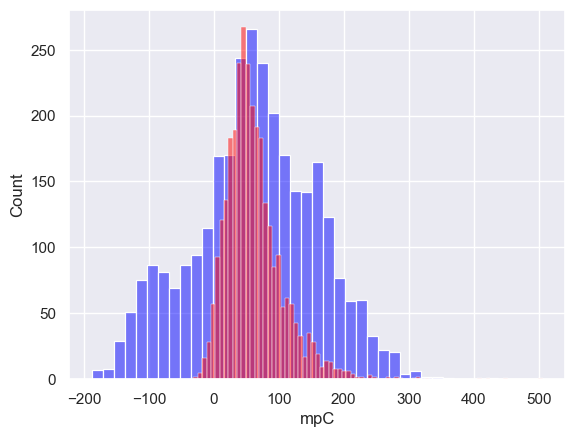

In [27]:
_ = sns.histplot(x=target, color='blue', alpha=0.5)
_ = sns.histplot(x=predicted, color='red', alpha=0.5)

The mean absolute error (MAE) is the average value of the absolute error for all predictions, and a key metric for our regression. At 67.4 °C, it is smaller than the standard deviation of the dataset itself (95.7 °C), but still substantial.

One way to estimate its “performance” is to compare it with the error made if the predictor was a “dummy” predictor, which always returned the average value of melting points in the training data set.

In [28]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(data, target)
dummy_predicted = dummy_regr.predict(data)
model_error = mean_squared_error(target, dummy_predicted)
print(f"The mean squared error of the dummy model is {model_error:.1f}")
model_error = mean_absolute_error(target, dummy_predicted)
print(f"The mean absolute error of the dummy model is {model_error:.1f} °C")

The mean squared error of the dummy model is 9148.5
The mean absolute error of the dummy model is 75.7 °C


##### We see that the MAE of our linear regression (67.4 °C) is better than a dummy predictor (75.7 °C), but not by much. We would like to improve the quality of our model, and one way to do this is to include more descriptors in the regression!

Before we do that, however, we want to know what the equation of our linear regression model is. It will be of the form:

$$ T_m = a \times M_w + b $$

where $T_m$ is the melting point, $M_w$ is the molar mass, and $a$ and $b$ are the model coefficients ($a$ is the _slope_ and $b$ is the _intercept_). We can get those coefficients from the trained model (the `linear_regression` object), by looking at its `coef_` and `intercept_` properties:

In [29]:
print('Slope is:', linear_regression.coef_)
print('Intercept is:', linear_regression.intercept_)

Slope is: [0.57013703]
Intercept is: -40.67161044939413


We see here that our model is (roughly):

$$T_m = 0.5701 M_w - 40.67$$

with $M_w$ in g/mol and $T_m$ in °C. We can plot that line on the graph of the data:

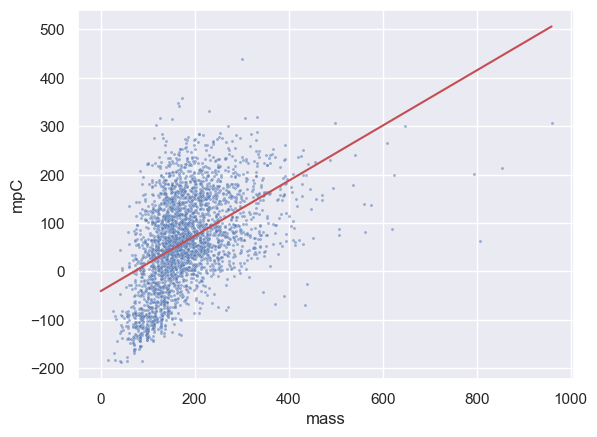

In [30]:
lineX = np.array([0, df['mass'].max()])
lineY = linear_regression.coef_ * lineX + linear_regression.intercept_

_ = sns.scatterplot(x=df['mass'], y=df['mpC'], s=5, alpha=0.5)
_ = sns.lineplot(x=lineX, y=lineY, color='r')

Visually, the result is stranger: our eye would probably prefer a trend line with a larger slope, that would fit better with the data in the 0–200 g/mol mass range. However, that would give points with high molar mass a really bad prediction of melting point (way too high). It is time to introduce more descriptors into the fit!

## Linear regression with multiple descriptors

Do our other descriptors show a direct correlation with the melting point of the molecules? Let’s see…

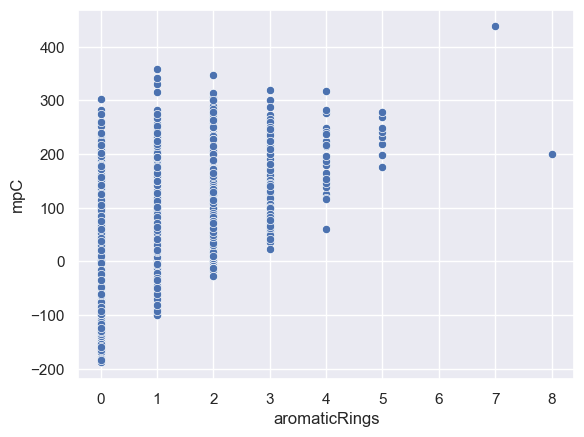

In [31]:
_ = sns.scatterplot(x=df['aromaticRings'], y=df['mpC'])

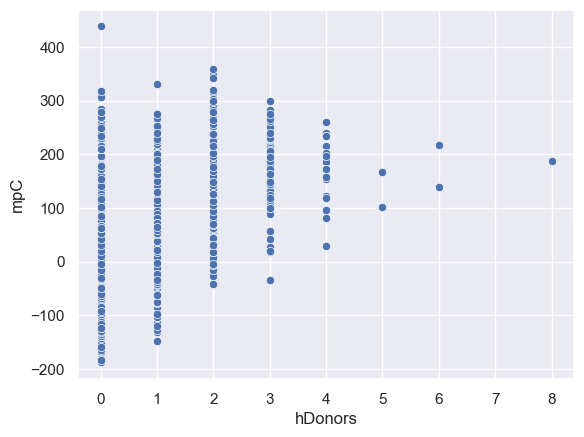

In [32]:
_ = sns.scatterplot(x=df['hDonors'], y=df['mpC'])

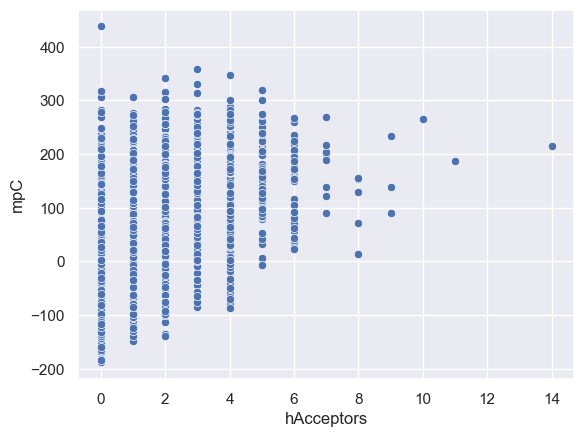

In [33]:
_ = sns.scatterplot(x=df['hAcceptors'], y=df['mpC'])

Maybe, maybe not… from visual inspection it is difficult to say for certain. If we introduce them as additional features in our linear regression model, what happens? We first create a model with 2 features: molar mass and number of aromatic rings.

In [34]:
data2 = df[['mass', 'aromaticRings']]
target = df['mpC']
linear_regression2 = LinearRegression()
linear_regression2.fit(data2, target)

predicted2 = linear_regression2.predict(data2)
model_error = mean_squared_error(target, predicted2)
print(f"The mean squared error of the optimal model is {model_error:.1f}")
model_error = mean_absolute_error(target, predicted2)
print(f"The mean absolute error of the optimal model is {model_error:.1f} °C")

The mean squared error of the optimal model is 6063.3
The mean absolute error of the optimal model is 62.6 °C


Introducing a second feature has improved the accuracy of our model: the MAE went down from 67.4 °C to 62.6 °C. Does the trend hold when we add additional descriptors?

In [35]:
data3 = df[['mass', 'aromaticRings', 'hAcceptors']]
target = df['mpC']
linear_regression3 = LinearRegression()
linear_regression3.fit(data3, target)

predicted3 = linear_regression3.predict(data3)
model_error = mean_squared_error(target, predicted3)
print(f"The mean squared error of the optimal model is {model_error:.1f}")
model_error = mean_absolute_error(target, predicted3)
print(f"The mean absolute error of the optimal model is {model_error:.1f} °C")

The mean squared error of the optimal model is 5055.3
The mean absolute error of the optimal model is 56.3 °C


In [36]:
data4 = df[['mass', 'aromaticRings', 'hAcceptors', 'hDonors']]
target = df['mpC']
linear_regression4 = LinearRegression()
linear_regression4.fit(data4, target)

predicted4 = linear_regression4.predict(data4)
model_error = mean_squared_error(target, predicted4)
print(f"The mean squared error of the optimal model is {model_error:.1f}")
model_error = mean_absolute_error(target, predicted4)
print(f"The mean absolute error of the optimal model is {model_error:.1f} °C")

The mean squared error of the optimal model is 3976.0
The mean absolute error of the optimal model is 48.9 °C


Indeed, as we add more features, the mean absolute error continues to go do:

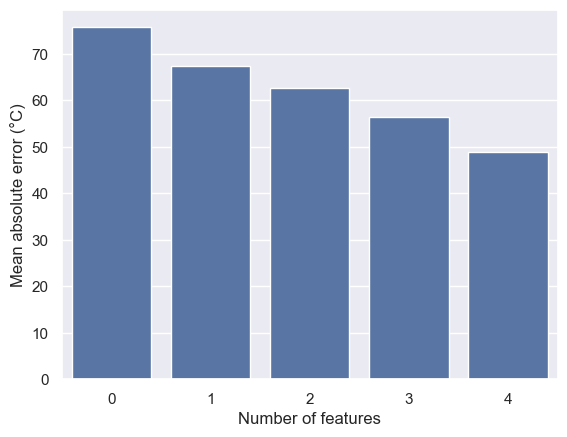

In [37]:
mae_dummy = mean_absolute_error(target, dummy_predicted)
mae1 = mean_absolute_error(target, predicted)
mae2 = mean_absolute_error(target, predicted2)
mae3 = mean_absolute_error(target, predicted3)
mae4 = mean_absolute_error(target, predicted4)

p = sns.barplot(x=[0, 1, 2, 3, 4], y=[mae_dummy, mae1, mae2, mae3, mae4])
_ = p.set(xlabel='Number of features', ylabel='Mean absolute error (°C)')

The mean average error of our linear regression model with 4 features is down to 49 °C. Do we consider that a “good” model? Let's compare this to state-of-the-art studies. One point of comparison can be found in the paper [“The development of models to predict melting and pyrolysis point data associated with several hundred thousand compounds mined from PATENTS”](https://doi.org/10.1186/s13321-016-0113-y), from Tetko et al (2016). Quoting from the conclusions of this ML study, which used large amounts of molecular descriptors and complex fingerprints:

> _The accuracy of the consensus melting point models for molecules from the drug-like region of chemical space was similar to their estimated experimental accuracy, 32 °C._

This shows that our simple model, based on only 4 molecular descriptors, is very simplistic and could be further improved.

## Interpreting the linear models

Probably the biggest advantage of linear models, and why they are so commonly used in many different fields, is that they have an direct interpretation that is easy to understand: namely, the coefficients (or _weights_) of the different features in the linear equation. As a result of the machine learning workflow, we therefore get not only a predictive model, but we also gain physical insight into the relationships between the various quantities.

Let us see what our final model (with 4 features) is:

In [38]:
print('Model features are:', list(data4.columns))
print('Model coefficients are:', linear_regression4.coef_)
print('Model intercept is:', linear_regression4.intercept_)

Model features are: ['mass', 'aromaticRings', 'hAcceptors', 'hDonors']
Model coefficients are: [ 0.24747218 40.59739655 11.90076924 42.32277697]
Model intercept is: -70.25597149257177


So our model is (approximately):

$$ T_m = 0.247 \times M_w + 40.6 \times N_{arom} + 11.9 \times N_{hA} + 42.3 \times N_{hD} - 70.3 $$

We see that all descriptors are positively correlated with the melting point. However, we cannot use the values of the coefficients to determine how important each feature is, because the features have very different ranges:

In [39]:
data4.describe()

,mass,aromaticRings,hAcceptors,hDonors
count,3025.000000,3025.000000,3025.000000,3025.000000
mean,180.528716,0.933223,1.783471,0.678678
std,80.114001,0.888736,1.484173,0.861752
min,16.043000,0.000000,0.000000,0.000000
25%,129.247000,0.000000,1.000000,0.000000
50%,166.180000,1.000000,2.000000,0.000000
75%,214.648000,1.000000,3.000000,1.000000
max,959.171000,8.000000,14.000000,8.000000


In our model, the coefficient for mass (0.247) is smaller than the others, but the molecular masses have a much larger range. They go from 16 to 960, while other descriptors are between 0 and 14.

To compare the linear model coefficients and interpret them as the _weight_ (or importance) of the features, we need to create a model where all features are rescaled to have comparable range. This process is called **standardization**. It is one of the types of [**preprocessing**](https://scikit-learn.org/stable/modules/preprocessing.html) that is routinely done on data before it fed into a ML algorithm.

The simplest standardization procedure is to ensure that all features have a mean of zero, and a standard deviation of one. This is achieved by removing the mean value of each feature, then scaling it (dividing by its standard deviation).

In [40]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

We have now created a `pipeline` object, which is ML workflow composed of two steps:
1. scaling of the features
2. linear regression based on scaled features

We can now fit this new two-step model, and interpret it:

In [41]:
pipeline.fit(data4, target)

predicted_scaled = pipeline.predict(data4)
model_error = mean_absolute_error(target, predicted_scaled)
print(f"The mean absolute error of the optimal model is {model_error:.1f} °C")

The mean absolute error of the optimal model is 48.9 °C


The resulting accuracy of the model are exactly the same as before, because we perform a _linear_ transformation of the features before a _linear_ model fitting. However, we can now interpret the coefficients of the rescaled model:

In [42]:
print('Model features are:', list(data4.columns))
print('Model coefficients are:', pipeline['linearregression'].coef_)
print('Model intercept is:', pipeline['linearregression'].intercept_)

Model features are: ['mass', 'aromaticRings', 'hAcceptors', 'hDonors']
Model coefficients are: [19.82270935 36.07440062 17.65987882 36.46572818]
Model intercept is: 62.25449586776859


We can see that, once we take normalization into account, all features have somewhat similar weight/importance in the model.

## Limitations of our linear model with 4 features

In order to understand the limitations of our model, let's plot the predicted values against real values, for all our dataset:

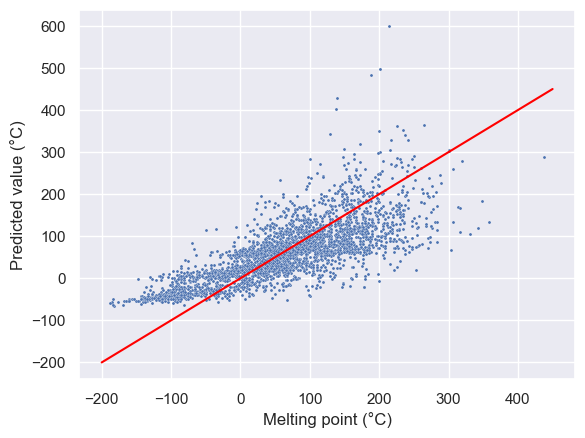

In [43]:
p = sns.scatterplot(x=target, y=predicted4, s=5)
sns.lineplot(x=[-200,450], y=[-200,450], color='red')
_ = p.set(xlabel='Melting point (°C)', ylabel='Predicted value (°C)')

A “perfect” model would have all data points fall on the $y=x$ line (the red line), meaning the predicted value would be perfectly predicted. We can see that there is some dispersion: this is the “model error” that we have numerically quantified with the MAE (mean average error) before.

We can also see that the error of the model is not homogeneously distributed throughout the dataset: it appears that the model is doing better for “medium” values of melting point, but is having trouble with low and high values. This is particular visible with low melting points: while some of the molecules can have a melting point that does down to almost –188 °C, our model never predicts anything lower than –66°C.

In [44]:
print('Lowest melting point:', np.min(target))
print('Lowest prediction:', np.min(predicted4))

Lowest melting point: -188.0
Lowest prediction: -66.28577525576087


We can confirm this by comparing the distribution of experimental and predicted values:

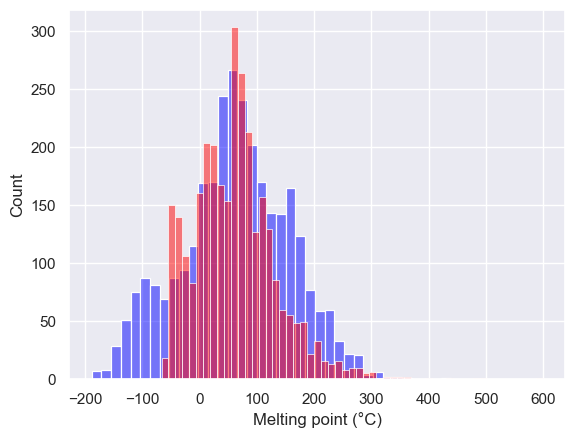

In [45]:
p = sns.histplot(x=target, color='blue', alpha=0.5)
sns.histplot(x=predicted4, color='red', alpha=0.5)
_ = p.set(xlabel='Melting point (°C)')

We can clearly see that the distribution of predicted values (in red) is narrower than that of experimental values (in blue).

## What to do next?

Now that we have seen the limitations of the current (very simple) approach, there are several ways we could improve this study. Here are some ideas for you to continue this project:

1. For the sake of simplicity, we have trained our model on _all_ of the data set, and measured its accuracy on this training data. However, we know that this is _not_ how proper model evaluation should be done: we should **split the data into train and test data sets**, and measure the accuracy of the model based on _test_ data (not seen during training). Even better would be to repeat this process through **cross-validation**.

2. Here, for each molecule, we have computed 4 descriptors of the structure using the [RDKit](https://www.rdkit.org) library. If we look at the [documentation](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors), we can see that it offers many more descriptors (17 at the time of writing). Would using **more descriptors** continue to improve our model? Is there a limit? Do we risk overfitting if we use many descriptors?

3. We have seen that our simple linear model has trouble describing extremal values of melting point (both high and low). Could **nonlinear models** perform better? How about [nearest-neighbors regression](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression), [decision tree](https://scikit-learn.org/stable/modules/tree.html#regression) models?

4. We have seen that our simple linear model has trouble describing extremal values of melting point. This could be because the range of values is large, and the problem is not linear in that space. Could we work around this problem by **feature engineering**, introducing some nonlinear features?